# Thermal circuit and state-space representation for a cubic Building
### Authors: Fabian Rechsteiner, Michael Wäspe

**Objectives:**
- Analyse a cubic building with 1 wall, 2 walls with a window and 3 adiabatic walls.
- Model the heat transfer in the building by a thermal circuit.
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

# Visualization of Model
## Model
A cubic building is simulated. This building has three walls made of concrete and insulation, two of which contain a window. The other three walls are assumed to be adiabatic. A 3D model of the building is shown in Figure 1. The adiabatic walls are shown in red. The aim is to simulate the temperature of the indoor air as a function of the outdoor temperature and solar radiation.
<div>
<img src="./figures_project/Building_Front.png" width="500"/>
<img src="./figures_project/Building_open.png" width="513"/>
</div>

> Figure 1. Simple Building with 3 walls considered as not perfectly isolated. The adiabatic walls are shown in red. One wall is missing in the illustration on the left and is intended to serve as a sectional model.

## Distances
Figure 2 shows the relevant dimensions of the building. These dimensions are defined later in the code.
<div>
<img src="./figures_project/Building_measured.png" width="600"/>
</div>

> Figure 2. Dimensioned representation of the cubic building model.

## Model Schematic
Figure 3 shows the thermal model of the cubic building shown in figure 1. It is visualized with the following colors:
- Red: Walls that contain a window
- Green: Wall without a window
- Blue: Windows
- Orange: Indoor air
- Purple: Longwave indoor radiation

The numbering will be used later to identify the walls and windows.

<div>
<img src="./figures_project/ThermalModelWithColors.png" width="1200"/>
</div>

> Figure 3. Cubic Building Model represented as a thermal model.

## Imports
Imports of all libraries that are needed.

In [1]:
# For High Resolution Screens
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

## Physical Properties

### Dimensions of the building

In [2]:
# Dimensions building
d_ins    = 0.08   #[m]
d_conc   = 0.2   #[m]
d_window = 0.04  #[m]
w_room   = 4     #[m]
w_window = 1.5   #[m]

### Thermo-physical properties and Dimension
The thermophysical properties of the air (in SI units) are:

In [3]:
# Properties Air
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) and the geometry (widths and surface areas) of the three materials (i.e., concrete, insulation) in SI units  of the wall without a window are:

In [4]:
# Properties wall without window
concrete_wow = {'Conductivity': 1.400,
                'Density': 2300.0,              # kg/m³
                'Specific heat': 880,           # J/(kg·K)
                'Width': d_conc,
                'Surface': w_room**2}

insulation_wow = {'Conductivity': 0.027,
                  'Density': 55.0,              # kg/m³
                  'Specific heat': 1210,        # J/(kg·K)
                  'Width': d_ins,
                  'Surface': w_room**2}
             
wall_wow = pd.DataFrame.from_dict({'Layer_out': concrete_wow,
                                   'Layer_in': insulation_wow},
                                   orient='index')          

# Print Data Frames
print('Properties of the wall without window:')
display(wall_wow)

Properties of the wall without window:


,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,16
Layer_in,0.027,55.0,1210,0.08,16


The [thermophysical properties](https://energieplus-lesite.be/donnees/enveloppe44/enveloppe2/conductivite-thermique-des-materiaux/) ([thermal conductivities](https://en.m.wikipedia.org/wiki/List_of_thermal_conductivities), [densities](https://en.wikipedia.org/wiki/Density) and [specific heat capacities](https://en.m.wikipedia.org/wiki/Table_of_specific_heat_capacities)) and the geometry (widths and surface areas) of the three materials (i.e., concrete, insulation, glass) in SI units  of the walls with a window are:

In [5]:
# Properties wall without window
concrete_ww = {'Conductivity': 1.400,
               'Density': 2300.0,              # kg/m³
               'Specific heat': 880,           # J/(kg·K)
               'Width': d_conc,
               'Surface': w_room**2-w_window**2}

insulation_ww = {'Conductivity': 0.027,
                  'Density': 55.0,              # kg/m³
                  'Specific heat': 1210,        # J/(kg·K)
                  'Width': d_ins,
                  'Surface': w_room**2-w_window**2}

glass_ww = {'Conductivity': 1.4,
            'Density': 2500,
            'Specific heat': 1210,
            'Width': d_window,
            'Surface': w_window**2}
             
wall_ww = pd.DataFrame.from_dict({'Layer_out': concrete_ww,
                                  'Layer_in': insulation_ww,
                                  'Window': glass_ww},
                                  orient='index')          

# Print Data Frames
print('Properties of the wall with window:')
display(wall_ww)

Properties of the wall with window:


,Conductivity,Density,Specific heat,Width,Surface
Layer_out,1.400,2300.0,880,0.20,13.75
Layer_in,0.027,55.0,1210,0.08,13.75
Window,1.400,2500.0,1210,0.04,2.25


### Radiation Properties

The [radiative properties](https://en.wikipedia.org/wiki/Emissivity#Absorptivity) of the surfaces are:
- long wave [emmisivity](https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html) of concrete (between normal and rough) and glass pyrex;
- short wave [absortivity of solar radiation](https://www.engineeringtoolbox.com/solar-radiation-absorbed-materials-d_1568.html) of white smooth surfaces;
- short wave [transmittance](https://www.engineeringtoolbox.com/optical-properties-glazing-materials-d_1355.html) of window glass (thickness of 4 mm);
- short wave [absortivity and transmittance](https://energieplus-lesite.be/techniques/enveloppe7/composants-de-l-enveloppe/vitrages/vitrage-permettant-le-controle-solaire/) of reflective blue window glass.

In [6]:
# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

# Stefan-Bolzmann constant
σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant
print('Stefan-Bolzmann constant: ',f'σ = {σ} W/(m²⋅K⁴)')

Stefan-Bolzmann constant:  σ = 5.67e-08 W/(m²⋅K⁴)


### Convection coefficients

Conventional values for the [convection coeficients](https://energieplus-lesite.be/theories/enveloppe9/echanges-chaleur-parois/resistance-thermique-d-echange-superficiel/) for indoor and outdoor convection in W/(m²⋅K) are:

In [7]:
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
print('Indoor and outdoor convection coeficients:')
display(h)

Indoor and outdoor convection coeficients:


,in,out
h,8.0,25


## Thermal network
Thermal networks (or circuits) are weighted [directed graphs](https://en.m.wikipedia.org/wiki/Directed_graph) in which:
- the **nodes** (or vertices) represent temperatures,  $\theta_i$, of geometrical points, surfaces or volumes;
- the oriented **branches** (or edges) represent thermal heat flow rates, $q_j$, betweenn the temperature nodes.

![basic_TC](./figures/A01_Basic_thermal_circuit.svg)
> Figure 4. Basic thermal network.

A thermal network has at least one oriented branch, $q$, and one node, $\theta$.

In a node there are a thermal capacity, $C_i$, (which can be positive or zero) and a heat flow rate source, $\dot Q_i$, (which can be zero).

On a branch, there are a conductane, $G_j > 0$, (which needs to be strictely pozitve) and a temperature source, $T_j$ (which can be zero).

The problem of analysis of thermal circuits (or the simulation problem, or the direct problem) is:

**given**:
- [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) $A$ which indicates how the nodes are connected by oriented branches;
- conductance diagonal matrix $G$;
- capacity diagonal matrix $C$;
- temperature source vector $b$;
- heat flow source vector $f$;

**find** the temperature vector $\theta$ and the flow rate vector $q.$


For the cubic building shown in Figure 1, heat transfert is:
- through the walls (concrete and insulation), 
- through the glass window,

The sources are:
- $T_o$ - outdoor temperature, °C;
- $\Phi_0$, $\Phi_3$ - solar radiation absorbed by the outdoor surface of the walls with a window;
- $\Phi_6$ - solar radiation absorbed by the outdoor surface of the wall without a window;
- $\Phi_1$, $\Phi_4$ - solar radiation absorbed by the indoor surface of the walls with a window;
- $\Phi_7$ - solar radiation absorbed by the indoor surface of the wall without a window;
- $\Phi_2$, $\Phi_5$ - solar radiation absorbed by the glass of the windows.

### Thermal coductances
#### Conduction
The conductances 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17 and 18 of the thermal circuit from Figure 3 model the heat transfer by [conduction](https://en.m.wikipedia.org/wiki/Thermal_conduction) (Conductances 5 and 12 later also include the convection of the windows). Conduction conductances, in W/K, are of the form:
$$G_{cd} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity), W/(m⋅K);
- $w$ - width of the material, m;
- $S$ - surface area of the wall, m².

In [55]:
# conduction
G_cond_wow = wall_wow['Conductivity'] / wall_wow['Width'] * wall_wow['Surface']
G_cond_ww = wall_ww['Conductivity'] / wall_ww['Width'] * wall_ww['Surface']
print('Conductance of the wall without a window:')
display(pd.DataFrame(G_cond_wow, columns={'Conductance'}))
print('Conductance of the walls with a window:')
display(pd.DataFrame(G_cond_ww, columns={'Conductance'}))

Conductance of the wall without a window:


ValueError: columns cannot be a set

#### Convection
The conductances 0, 5, 7, 12, 14, 19, 20, 21, 22, 23 model the heat transfer by [convection](https://en.m.wikipedia.org/wiki/Convection_(heat_transfer). Convection conductances, in W/K, are of the form:
$$G_{cv} = {h S}$$
where:
- $h$ is the [convection coefficient](https://en.m.wikipedia.org/wiki/Heat_transfer_coefficient), W/(m²⋅K);
- $S$ - surface area of the wall, m².

In [9]:
# convection
G_conv_wow = h * wall_wow['Surface']['Layer_out']   # wall without window
G_conv_ww  = h * wall_ww['Surface']['Layer_in']   # wall
G_conv_g    = h * wall_ww['Surface']['Window']     # glass

print('Convection Coefficients of wall without window:')
display(G_conv_wow)
print('Convection Coefficients of wall with window:')
display(G_conv_ww)
print('Convection Coefficients of window:')
display(G_conv_g)

Convection Coefficients of wall without window:


,in,out
h,128.0,400


Convection Coefficients of wall with window:


,in,out
h,110.0,343.75


Convection Coefficients of window:


,in,out
h,18.0,56.25


#### Long wave radiation
##### View factors inside the building

The view factor $F_{i,j}$ is defined as *the proportion of radiation leaving surface $i$ that is intercepted by surface $j$*. A simplified model is used to determine the viewfactors.

A simplified relation is used to calculate the view factors of the cubic building:

The view factors are defined by:
$$\begin{cases}
F_{i,j} = \frac{S_j}{S_T -S_i}\\ 
F_{i,i} = 0
\end{cases}$$

where $S_{T} = \sum_{j=0}^{n-1} S_j$, i.e. the surface $S_i$ is not included in the total surface $S_{T,i} = S_T - S_i$. 

In this case, the reciprocty theorem is generally not respected:
$$F_{i, j} S_i = \frac{S_j}{S_T - S_i} S_i \neq F_{j, i} S_j = \frac{S_i}{S_T - S_j} S_j$$
but the summation rule is respected:
$$ \sum_{i=0}^{n-1} F_{i, j} = \frac{1}{S_T - S_i} \sum_{\substack{j=0\\i\neq j}}^{n-1} S_j = 1 $$

To calculate the view factors, we use a simplified representation as shown in Figure 5. To ensure that the view factors are correct, the areas of the adiabatic walls must also be taken into account in the total area. The designations of the view factors in the following code are based on the designations in Figure 5. The numbering of the walls and windows in Figure 5 refers to the numbering in Figure 3.

<div>
<img src="./figures_project/viewfactorsSimplifiedRepresentation.png" width="600"/>
</div>

> Figure 5. Simplified representation of the relevant view factors of the cubic building model.

Note: The view factor between two surfaces, $j,k$ that are in the same plane (e.g. a window and a wall) is zero,
$$F_{j,k} = F_{k,j}=0$$

Therefore the total surface $S_{T,i}$ should be:
$$S_{T,i} = \sum_{j=0}^{n-1} S_j - \sum_k S_k$$
i.e. the surfaces $S_k$ in the same plan with the surface $S_i$ are not included in $S_{T,i}$.


In [10]:
# Total surface
S_t = wall_wow['Surface']['Layer_in']*6
# Viewfactors (simplified)
S_1_3 = wall_ww['Surface']['Layer_in']  / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])    # (#3 / (total - #1 - #2)
S_1_4 = wall_ww['Surface']['Window']    / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])    # (#4 / (total - #1 - #2)
S_1_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])    # (#5 / (total - #1 - #2)
S_2_3 = wall_ww['Surface']['Layer_in']  / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])  # (#3 / (total - #2 - #1)
S_2_4 = wall_ww['Surface']['Window']    / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])  # (#4 / (total - #2 - #1)
S_2_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])  # (#5 / (total - #2 - #1)
S_3_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Layer_in'] - wall_ww['Surface']['Window'])    # (#5 / (total - #3 - #4)
S_4_5 = wall_wow['Surface']['Layer_in'] / (S_t - wall_ww['Surface']['Window']   - wall_ww['Surface']['Layer_in'])  # (#5 / (total - #4 - #3)

##### View factor between tilted outdoor walls and sky

The view factor between the top surface of finite wall $w$ tilted relative to an infinite plane of the ground $g$ is [[5](http://www.thermalradiation.net/sectionc/C-9.html), [6](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), eq. 4.18]:

$$ F_{w,g} = \frac {1 - \cos \beta}{2}$$

Therefore, the view factor between the tilted wall $w$ and the sky dome $s$ is [[6](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), eq. 4.17]:
$$ F_{w,s} = 1 - F_{w,g} = \frac {1 + \cos \beta}{2}$$

##### Thermal network for long wave radiation

The long-wave heat exchange between surfaces may be modelled by using the concept of [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) and then linearizing the radiative heat exchange. 

![LW_rad_excg](./figures/03_LW_rad_excg.svg)
> Figure 6. Radiative long-wave heat exchange between two surfaces: a) modeled by [emmitance](https://en.m.wikipedia.org/wiki/Radiant_exitance) (source) and [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) (nodes); b) modeled by linearization of emmitance (temperature sources) and radiosity (temperature nodes).

For two surfaces the [conductances](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy), in m², for radiative heat exchange expressed by using the emmitance (or the [radiant excitance](https://en.m.wikipedia.org/wiki/Radiant_exitance))  of the black body, the [radiosity](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)), and the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of view factors are:

$$G_{1}^{r} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2}^{r} = F_{1,2} S_1 = F_{2,1} S_2$$

$$G_{2}^{r} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

where:
- $\varepsilon_1$ and $\varepsilon_2$ are the [emmisivities](https://en.m.wikipedia.org/wiki/Emissivity) of the surfaces 1 and 2;
- $S_1$ and $S_2$ - areas of the surfaces 1 and 2, m²;
- $F_{1,2}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surfaces 1 and 2.


The [net flows leaving the surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) are:

$$q_{net,1} = \frac{\varepsilon_1}{1 - \varepsilon_1} S_1 (M^o_1 - J_1)= G^r_1 (M_1^o - J_1)$$

$$q_{net,2} = \frac{\varepsilon_2}{1 - \varepsilon_2} S_2 (M^o_2 - J_2)= G^r_2 (M_2^o - J_2)$$

respectively, where:
- $M^o_1$ and $M^o_2$ are the [emmitances](https://en.m.wikipedia.org/wiki/Radiant_exitance) of the surfaces 1 and 2 when emmiting as black bodies, $M^o = \sigma T^4$, W/m²;
- $J_1$ and $J_2$ - [radiosities](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)) of surfaces 1 and 2, W/m²;
- $G^r_1$ and $G^r_2$ - conductances for long wave radiative heat exchange, m².

The [net flow between surfaces 1 and 2](https://en.m.wikipedia.org/wiki/Radiosity_(radiometry)#Circuit_analogy) is:

$$q_{1,2} = F_{1,2} S_1 (J_1 - J_2) = F_{2,1} S_2 (J_1 - J_2)= G_{1,2}^r (J_1 - J_2)$$

In order to express the long-wave radiative exchange as a function of temperature differences, a linearization of the difference of temperatures $T_1^4 - T_2^4$ may be used:

$$T_1^4 - T_2^4 = (T_1^2 + T_2^2)(T_1^2 - T_2^2) = (T_1^2 + T_2^2)(T_1 + T_2)(T_1 - T_2) = 4 \bar{T}^3 (T_1 - T_2)$$

where the mean temperature $\bar{T}$, measured in kelvin, is:

$$\bar{T} =\sqrt[3]{ \frac{(T_1^2 + T_2^2)(T_1 + T_2)}{4}}$$

The evaluation of mean temperaure, $\bar{T}$, requires the values of the surface tempetratures, $T_1$ and $T_2$. An initial guess can be used (and then an iterative process, for a more precise evaluation).

After linearization, the conductances, in W/K, for radiative heat exchange are:

$$G_{1} = 4 \sigma \bar{T}^3 \frac{\varepsilon_1}{1 - \varepsilon_1} S_1$$

$$G_{1,2} = 4 \sigma \bar{T}^3 F_{1,2} S_1 = 4 \sigma \bar{T}^3 F_{2,1} S_2$$

$$G_{2} = 4 \sigma \bar{T}^3 \frac{\varepsilon_2}{1 - \varepsilon_2} S_2$$

In the cubic building model, conductances 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35 and 36 represent the longwave radiation heat exchange between the different surfaces. This part of the thermal network can be seen in Figure 7.

<div>
<img src="./figures_project/ThermalModel_radiation.png" width="600"/>
</div>

> Figure 7. Thermal network of long wave radiation in cubic building model

In [11]:
# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW24 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_ww['Surface']['Layer_in']
GLW25 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall_ww['Surface']['Window']
GLW26 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_ww['Surface']['Layer_in']
GLW27 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall_ww['Surface']['Window']
GLW28 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall_wow['Surface']['Layer_in']
GLW29 = 4 * σ * Tm**3 * S_1_3 * wall_ww['Surface']['Layer_in']
GLW30 = 4 * σ * Tm**3 * S_1_4 * wall_ww['Surface']['Layer_in']
GLW31 = 4 * σ * Tm**3 * S_1_5 * wall_ww['Surface']['Layer_in']
GLW32 = 4 * σ * Tm**3 * S_2_3 * wall_ww['Surface']['Window']
GLW33 = 4 * σ * Tm**3 * S_2_4 * wall_ww['Surface']['Window']
GLW34 = 4 * σ * Tm**3 * S_2_5 * wall_ww['Surface']['Window']
GLW35 = 4 * σ * Tm**3 * S_3_5 * wall_ww['Surface']['Layer_in']
GLW36 = 4 * σ * Tm**3 * S_4_5 * wall_ww['Surface']['Window']

#### Conductances in series and/or parallel
If conductances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in [series or parallel](https://en.m.wikipedia.org/wiki/Series_and_parallel_circuits) (depending on the connection). Let's consider, for example, the outdoor side of the glass windows (Figure 3): the outdoor convection conductance and the conduction conductance (corresponding to half of the width of the glass) are in series:

$$ G_{gs} = \frac{1}{1/G_{g,cv.out } + 1/(2 G_{g,cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

In [12]:
# glass: convection outdoor & conduction
G_conv_cond_g = float(1 / (1 / G_conv_g['out'] + 1 / (G_cond_ww['Window']/2)))

C:\Users\fabia\AppData\Local\Temp\ipykernel_808\3029058917.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G_conv_cond_g = float(1 / (1 / G_conv_g['out'] + 1 / (G_cond_ww['Window']/2)))


### Thermal capacities
#### Walls
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the walls and the windows, in J/kg, are:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the mass of the wall or the window, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity), J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density), kg/m³;
- $w_w$ - width of the wall or window, m;
- $S_w$ - surface area of the wall or window, m².

In [13]:
C_wow = wall_wow['Density'] * wall_wow['Specific heat'] * wall_wow['Surface'] * wall_wow['Width']
C_ww  = wall_ww['Density'] * wall_ww['Specific heat'] * wall_ww['Surface'] * wall_ww['Width']

print('Capacities of wall without a window:')
display(pd.DataFrame(C_wow, columns={'Capacity'}))
print('Capacities of walls with a window:')
display(pd.DataFrame(C_ww, columns={'Capacity'}))

Capacities of wall without a window:


ValueError: columns cannot be a set

#### Air
Similarly, the thermal capacity of the air, in J/kg, is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [14]:
Va = w_room**3 # m³, volume of air
C_air = air['Density'] * air['Specific heat'] * Va

### Temperature sources

The [temperature sources](https://en.m.wikipedia.org/wiki/Voltage_source#Ideal_voltage_sources) model temperatures which vary independently of what happens in the themal circuit; they are inputs of the physical model. Generally, the temperature sources are:
- outdoor air and ground temperature;
- temperature of adjacent spaces which have controlled temperature;
- setpoint temperature.

In this simulation, only the outside temperature is taken into account as a temperature source.

#### Outdoor air and ground temperature
The hourly values of outdoor temperatures can be obtained from weather data files downloadable from the [Repository of free climate data for building performance simulation](http://climate.onebuilding.org) or from [Weather data for EnergyPlus®](https://energyplus.net/weather) (see the tutorial on [Weather data and solar radiation](01WeatherData.ipynb)).

### Heat flow rate sources
The [heat flow rate sources](https://en.m.wikipedia.org/wiki/Current_source#Background) model flow rates which vary idependently of what happens in the themal circuit. They are inputs of the physical model. Generally, the heat flow rate sources are:
- solar radiation absorbed by the walls;
- internal auxiliary sources.

#### Solar radiation absorbed by the walls

The [direct](https://en.m.wikipedia.org/wiki/Direct_insolation), diffuse and reflected components of the [solar radiation](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface can be estimated from weather data by using the function `sol_rad_tilt_surf` from the module `dm4bem` (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

##### External wall

The radiation absorbed by the outdoor surface of the wall is:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:
- $\alpha_{w,SW}$ is the [absorptance](https://en.m.wikipedia.org/wiki/Absorptance) of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total [solar irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on the wall, W/m².

##### Internal walls

The total shortwave incident irradiance on the wall $i$, $E_i$, may be estimated as a function of the direct solar irradiance incident on the surface of the walls, $E_{i}^{o}$:

$$S_i E_i = S_i E_{i}^{o} + \sum_{j=1}^{n} F_{j,i} S_j \rho_j E_j$$

where:
- $S_i$ is the area of the surface of the wall $i$, m²;
- $E_i$ - total irradiance received directly and by multiple reflections on surface $i$, W/m²;
- $E_{i}^{o}$ - irradiance received directly from the sun on surface $i$, W/m²;
- $F_{j, i}$ - [view factor](https://en.m.wikipedia.org/wiki/View_factor) between surface $j$ and surface $i$, $0 ⩽ F_{j,i} ⩽ 1$;
- $\rho_j$ - [reflectance](https://en.m.wikipedia.org/wiki/Reflectance) of surface $j$, $0 ⩽ \rho_j ⩽ 1$.


By taking into account the [reciprocity](https://en.m.wikipedia.org/wiki/View_factor#Reciprocity) of the view factors: $S_i F_{i,j} = S_j F_{j,i}$, the set of previous equation becomes:

$$
\begin{bmatrix}
1 - \rho_1 F_{1,1} & - \rho_2 F_{1,2}     & ...  & - \rho_n F_{1,n}\\ 
- \rho_1 F_{2,1}   & 1 - \rho_2 F_{2,2}  & ...  & - \rho_n F_{2,n} \\ 
...                         & ...                            & ...  & ... \\ 
- \rho_1 F_{n,1}  & - \rho_2 F_{n,1}      & ... & 1 - \rho_n F_{n,n}
\end{bmatrix} \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix} = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}
$$

or

$$(I - \rho \circ F) E = E^o$$

The unknown total [irradiances](https://en.m.wikipedia.org/wiki/Irradiance) on walls, in W/m², are then

$$ E = (I - \rho \circ F)^{-1} E^o$$

where:

- the symbol $\circ$ represents the [Hadamard (or element-wise) product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices));

$I =\begin{bmatrix}
1 & 0 & ... & 0 \\ 
0 & 1 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & 1 
\end{bmatrix}, $ is the [identity matrix](https://en.m.wikipedia.org/wiki/Identity_matrix);

$\rho = \begin{bmatrix}
\rho_1\\ 
\rho_2\\ 
...\\ 
\rho_n
\end{bmatrix}$ - vector of [reflectances](https://en.m.wikipedia.org/wiki/Reflectance), $0 \le \rho_{i,j} \le 1$;

$F = \begin{bmatrix}
F_{1,1} & F_{1,2} & ... & F_{1,n}\\ 
F_{2,1} & F_{2,2} & ... & F_{2,n} \\ 
... & ... & ... & ...\\ 
F_{n,1} & F_{n,2} & ... & F_{n,n}
\end{bmatrix}$ - matrix of [view factors](https://en.m.wikipedia.org/wiki/View_factor), $0 \le F_{i,j} \le 1$;

$E^o = \begin{bmatrix}
E_{1}^{o}\\ 
E_{2}^{o}\\ 
...\\ 
E_{n}^{o}
\end{bmatrix}$ - vector of [direct solar irradiances](https://en.m.wikipedia.org/wiki/Solar_irradiance), W/m²;

$E = \begin{bmatrix}
E_1\\ 
E_2\\ 
...\\ 
E_n
\end{bmatrix}$ - vector of unknown total irradiances, W/m².


The radiative short wave (i.e. solar) heat flow rate on each surface is:

$$ \Phi = S E $$

where:

$\Phi = \begin{bmatrix}
\Phi_1\\ 
\Phi_2\\ 
...\\ 
\Phi_n
\end{bmatrix}$ - vector of total heat flow rates due to solar radiation, W; 

$S =\begin{bmatrix}
S_1 & 0 & ... & 0 \\ 
0 & S_2 & ... & 0 \\ 
... & ... & ... & ...\\ 
0 & 0 & ... & S_n 
\end{bmatrix}$ - matrix of surface areas of walls $i$, m².

## System of algebraic-differential equations (DAE)

The analysis of a thermal circuit, or the direct problem ([Ghiaus 2022](https://hal.archives-ouvertes.fr/hal-03484064/document)), means to find the temperatures in the nodes, $\theta$, and the heat flows on the branches, $q$, i.e. to solve for $\theta$ and $q$ the system of [Differential-Algebraic Equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations) (Figures 3 and 4):

$$\left\{\begin{array}{ll}
C \dot{\theta} = -(A^T G A) \theta + A^T G b + f\\ 
q = G (-A \theta + b)
\end{array}\right.$$

where:
- $\theta$ is the temperature vector of size $n_\theta$ equal to the number of nodes;
- $q$ - heat flow vector of size $n_q$ equal to the number of branches;
- $A$ - [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) of size $n_q$ rows and $n_{\theta}$ columns, where $n_q$ is the number of flow branches and $n_{\theta}$  is the number of temperature nodes. It shows how the temperature nodes are connected by oriented branches of heat flows:
    - if flow *m* enters into node *n*, then the element (*m, n*) of the matrix $A$ is 1, i.e., $A_{m,n} = 1$;
    - if flow *m* exits from node *n*, then the element (*m, n*) of the matrix $A$ is -1, i.e., $A_{m,n} = -1$, ; 
    - if flow *m* is not connected to node *n*, then the element (*m, n*) of the matrix $A$ is 0, i.e., $A_{m,n} = 0$.

- $G$ - conductance diagonal matrix of size $n_q \times n_q$,  where $n_q$ is the number of flow branches: diagonal matrix containing the conductances. Each branch $k$ needs to contain a conductance $0 < G_{k,k} < \infty $. 

- $C$ - capacity diagonal matrix of size $n_θ \times n_θ$,  where $n_θ$ is the number of temperature nodes: diagonal matrix containing the capacities. If there is no capacity in the node *n*, then $C_{n, n} = 0$.

- $b$ - temperature source vector of size $n_q$: if there is no temperature source on the branch *m*, then $b_m = 0$.

- $f$ - heat flow source vector of size $n_θ$: if there is no heat flow source in the node *n*, then $f_n = 0$.

The resolution is first done for temperatures, $\theta$, by solving the equation
$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
which, generally, is a system of differential-algebraic equations (DAE). Then, the heat flow rates are found from the equation
$$q = G (-A \theta + b)$$


### A: incidence matrix

The [incidence matrix](https://en.m.wikipedia.org/wiki/Incidence_matrix) is:

$A_{kl} = \begin{cases}\phantom{-}
0 & \text{if branch } q_k \text{ is not connected to node }  \theta_l \\ 
+1 & \text{if branch } q_k \text{ enters into node }  \theta_l\\ 
-1 & \text{if branch } q_k \text{ gets out of node }  \theta_l 
\end{cases}$

For the themal circuit shown in Figure 3,

$ A = \begin{cases}
A_{0,0} = 1\\ 
A_{1,0} = -1, A_{1,1} = 1\\ 
...\\
A_{36,24} = 1\\
\end{cases}$

In [15]:
# A --> 37x25
#              Θ0    Θ1    Θ2    Θ3    Θ4    Θ5    Θ6    Θ7    Θ8    Θ9    Θ10   Θ11   Θ12   Θ13   Θ14   Θ15   Θ16   Θ17   Θ18   Θ19   Θ20   Θ21   Θ22   Θ23   Θ24 
A = np.array([[ 1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q0
              [-1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q1
              [ 0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q2
              [ 0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q3
              [ 0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q4
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q5
              [ 0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q6
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q7
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q8
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q9
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q10
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q11
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q12
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q13
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q14
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q15
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q16
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q17
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q18
              [ 0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q19
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q20
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q21
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q22
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0  ,  0  ,  0  ,  0 ],  # q23
              [ 0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0  ,  0 ],  # q24
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0  ,  0 ],  # q25
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0  ,  0 ],  # q26
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1  ,  0 ],  # q27
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  0  ,  0  ,  1 ],  # q28
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1  ,  0  ,  0 ],  # q29
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  1  ,  0 ],  # q30
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  0  ,  1 ],  # q31
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  0  ,  1 ],  # q32
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1  ,  0 ],  # q33
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1  ,  0  ,  0 ],  # q34
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  0  ,  1 ],  # q35
              [ 0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  ,  0  , -1  ,  1 ]]) # q36

### G: conductance matrix

The conductance matrix of the themal circuit shown in Figure 3 is diagonal:

$ G = \begin{cases}
G_{0,0} = G_{7,7} = G_{ww,cv,Layer\,out} & \text{convection outside surface of the walls with a window}\\
G_{1,1} = G_{2,2} = G_{8,8} = G_{9,9} = 2G_{ww,cd,Layer\,out} & \text{conduction in half width of the outer layer of the walls with a window}\\
G_{3,3} = G_{4,4} = G_{10,10} = G_{11,11} = 2G_{ww,cd,Layer\,in} & \text{conduction in half width of the inner layer of the walls with a window}\\
G_{5,5} = G_{12,12} = G_{window,cdcv} & \text{conduction in half width and convection outside surface of the windows }\\
G_{6,6} = G_{13,13} = 2G_{window,cd} & \text{conduction in half width of the windows }\\
G_{14,14} = G_{wow,cv,Layer\,out} & \text{convection outside surface of the walls without a window}\\
G_{15,15} = G_{16,16} = 2G_{wow,cd,Layer\,out} & \text{conduction in half width of the outer layer of the walls without a window}\\
G_{17,17} = G_{18,18} = 2G_{wow,cd,Layer\,in} & \text{conduction in half width of the inner layer of the walls without a window}\\
G_{19,19} = G_{21,21} = G_{ww,cv,Layer\,in} & \text{convection inside surface of the walls with a window}\\
G_{20,20} = G_{22,22} = G_{window,cv,Layer\,in} & \text{convection inside surface of the windows}\\
G_{23,23} = G_{wow,cv,Layer\,in} & \text{convection inside surface of the walls without a window}\\
G_{24,24} = G_{LW24} & \text{Long wave radiation conductance}\\
G_{25,25} = G_{LW25} & \text{Long wave radiation conductance}\\
G_{26,26} = G_{LW26} & \text{Long wave radiation conductance}\\
G_{27,27} = G_{LW27} & \text{Long wave radiation conductance}\\
G_{28,28} = G_{LW28} & \text{Long wave radiation conductance}\\
G_{29,29} = G_{LW29} & \text{Long wave radiation conductance}\\
G_{30,30} = G_{LW30} & \text{Long wave radiation conductance}\\
G_{31,31} = G_{LW31} & \text{Long wave radiation conductance}\\
G_{32,32} = G_{LW32} & \text{Long wave radiation conductance}\\
G_{33,33} = G_{LW33} & \text{Long wave radiation conductance}\\
G_{34,34} = G_{LW34} & \text{Long wave radiation conductance}\\
G_{35,35} = G_{LW35} & \text{Long wave radiation conductance}\\
G_{36,36} = G_{LW36} & \text{Long wave radiation conductance}\\
\end{cases}$

Note: The conductances $G_{LW24}$ to $G_{LW36}$ can be interpreted using Figures 3 and 5.

In [16]:
# G --> 37x37
G = np.zeros((37, 37))
# Wall with window
G[0,0]   = G_conv_ww['out']
G[1,1]   = G_cond_ww['Layer_out']*2
G[2,2]   = G_cond_ww['Layer_out']*2
G[3,3]   = G_cond_ww['Layer_in']*2
G[4,4]   = G_cond_ww['Layer_in']*2
# Window
G[5,5]   = G_conv_cond_g  # Convection and conduction of window
G[6,6]   = G_cond_ww['Window']*2
# Wall with window
G[7,7]   = G_conv_ww['out']
G[8,8]   = G_cond_ww['Layer_out']*2
G[9,9]   = G_cond_ww['Layer_out']*2
G[10,10] = G_cond_ww['Layer_in']*2
G[11,11] = G_cond_ww['Layer_in']*2
# Window
G[12,12] = G_conv_cond_g  # Convection and conduction of window
G[13,13] = G_cond_ww['Window']*2
# Wall without window
G[14,14] = G_conv_wow['out']
G[15,15] = G_cond_wow['Layer_out']*2
G[16,16] = G_cond_wow['Layer_out']*2
G[17,17] = G_cond_wow['Layer_in']*2
G[18,18] = G_cond_wow['Layer_in']*2
# Convections to inside air
G[19,19] = G_conv_ww['in']
G[20,20] = G_conv_g['in']
G[21,21] = G_conv_ww['in']
G[22,22] = G_conv_g['in']
G[23,23] = G_conv_wow['in']
# Long wave radiation
G[24,24] = GLW24
G[25,25] = GLW25
G[26,26] = GLW26
G[27,27] = GLW27
G[28,28] = GLW28
G[29,29] = GLW29
G[30,30] = GLW30
G[31,31] = GLW31
G[32,32] = GLW32
G[33,33] = GLW33
G[34,34] = GLW34
G[35,35] = GLW35
G[36,36] = GLW36

C:\Users\fabia\AppData\Local\Temp\ipykernel_808\2523488498.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G[0,0]   = G_conv_ww['out']
C:\Users\fabia\AppData\Local\Temp\ipykernel_808\2523488498.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G[7,7]   = G_conv_ww['out']
C:\Users\fabia\AppData\Local\Temp\ipykernel_808\2523488498.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G[14,14] = G_conv_wow['out']
C:\Users\fabia\AppData\Local\Temp\ipykernel_808\2523488498.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  G[19,19] = G_conv_ww['in']
C:\Users\fabia\AppData\Local\Temp\ipykernel_8

### C: capacity matrix

The capacity matrix of the themal circuit shown in Figure 3 is diagonal:

$ C = \begin{cases}
C_{1,1} = C_{8,8} = C_{ww,Layer\,out} & \text{outer layer of the walls with a window}\\
C_{3,3} = C_{10,10} = C_{ww,Layer\,in} & \text{inner layer of the walls with a window}\\
C_{5,5} = C_{12,12} = C_{window} & \text{glass of the windows}\\
C_{15,15} = C_{wow,Layer\,out} & \text{outer layer of the wall without a window}\\
C_{17,17} = C_{wow,Layer\,in} & \text{inner layer of the wall without a window}\\
C_{19,19} = C_{Air} & \text{air of the room}\\ 
\end{cases}$

In [17]:
# C --> 25x25
C = np.zeros((25, 25))
# Wall with window
C[1,1] = C_ww['Layer_out']
C[3,3] = C_ww['Layer_in']
# Window
C[5,5] = C_ww['Window']
# Wall with window
C[8,8] = C_ww['Layer_out']
C[10,10] = C_ww['Layer_in']
# Window
C[12,12] = C_ww['Window']
# Wall without window
C[15,15] = C_wow['Layer_out']
C[17,17] = C_wow['Layer_in']
# Inside air
C[19,19] = C_air

### b: temperature source vector

The vector of *temperature sources* is $b$, of size $n_q$, the number of branches (in this example 37). An element of the vector $b$ corresponding to a branch without a source is zero. If the flow in a source is from the low potential to the high potential of the source (i.e. from - to +), then the source is positive. If the flow rate in the temperature source is from high potential to low potential (i.e. from + to -), then the source is negative (see [passive sign convention](https://en.m.wikipedia.org/wiki/Passive_sign_convention)). 

For the thermal circuit shown in Figure 3,

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &T_o  &0  &T_o  &0  &0  &0  &0  &T_o  &0  &T_o  &0  &...  &0
\end{matrix}]^T$$

i.e. $b_0 = b_5 = b_7 = b_{12} = b_{14} = T_o$ where $T_o$ is the outdoor temperature, °C.

Since the temperature sorces $T_o$ is a [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $b$ the branches which contain temperature sources are designated by $1$ and the branches without any temeprature source by $0$.

In [18]:
# b --> 37x1
b = np.zeros(37)            # nodes
b[[0, 5, 7, 12, 14]] = 1    # nodes with temperature sources

### f: heat flow source vector

The vector of *heat sources* is $f$, of size $n_{\theta}$, the number of nodes. An element of the vector $f$ corresponding to a node without a heat source is zero.

For the thermal circuit shown in Figure 3,

$$f = [\begin{matrix}
\Phi_0 &0  &0  &0  &\Phi_1  &\Phi_2  &0  &\Phi_3  &0  &0  &0  &\Phi_4  &\Phi_5  &0  &\Phi_6  &0  &0  &0  &\Phi_7  &0  &...  &0
\end{matrix}]^T$$

i.e. $f_0 = \Phi_0$, $f_4 = \Phi_1$, $f_5 = \Phi_2$, $f_7 = \Phi_3$, $f_{11} = \Phi_4$, $f_{12} = \Phi_5$, $f_{14} = \Phi_6$, $f_{18} = \Phi_7$, where:
- $\Phi_0$, $\Phi_3$ - solar radiation absorbed by the outdoor surfaces of the walls with a window;
- $\Phi_1$, $\Phi_4$ - solar radiation absorbed by the indoor surfaces of the walls with a window;
- $\Phi_2$, $\Phi_5$ - solar radiation absorbed by the windows.
- $\Phi_6$ - solar radiation absorbed by the outdoor surface of the wall without a window;
- $\Phi_7$ - solar radiation absorbed by the indoor surface of the wall without a window;

Since the flow rate sorces $\Phi_0$ to $\Phi_7$ are [time series](https://en.m.wikipedia.org/wiki/Time_series), in vector $f$ the nodes which contain flow rate sources are designated by $1$ and the  nodes without any flow rate source by $0$.

In [19]:
# f --> 25x1
f = np.zeros(25)                        # nodes
f[[0, 4, 5, 7, 11, 12, 14, 18]] = 1     # nodes with heat-flow sources

### y: output vector

The vector of outputs is $y$, of size $n_{\theta}$, the number of nodes (in this example 25). The non-zero values of $y$ indicate the nodes which are the outputs of the model.

For the thermal circuit shown in Figure 3, if the output is the indoor air temperature, then the output vector is:

$$y = [\begin{matrix}
0  &0  &...  &0  &\theta_{19} 
\end{matrix}]^T$$

In vector $y$, the nodes for which the temperatures are outputs are noted by $1$ and the other nodes by $0$.

In [20]:
# y --> 25x1
y = np.zeros(25)         # nodes
y[[19]] = 1              # nodes (temperatures) of interest

## State-space representation
The [differential-algebraic system of equations (DAE)](https://en.m.wikipedia.org/wiki/Differential-algebraic_system_of_equations)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed in [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation) ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)):

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_s + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

where:
- $\theta_s$ is the vector of state variables which are the temperatures of nodes containing capacities; the elements are in the same order as in the vector of temperatures, $\theta$; its dimension, $\dim \theta_s$, is equal to the number of capacities from the thermal network; for the circuit presented in Figure 3, $\theta_s = [\theta_1, \theta_3, \theta_6, \theta_7]^T$;

- $u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$ - vector of inputs of dimension $\dim u$ equal to the number of sources (of temperaure, $b_T$, and heat flows, $f_Q$) of the thermal network, where:

    - vector $b_T$ of nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, $b_T = [T_o, T_o, T_o, T_o, T_o]^T$ corresponds to branches 0, 5, 7, 12 and 14; 
    - vector $f_Q$ of nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3, $f_Q = [\Phi_0, \Phi_1, \Phi_2, \Phi_3, \Phi_4, \Phi_5, \Phi_6, \Phi_7]^T$ corresponds to nodes 0, 4, 5, 7, 11, 12, 14 and 18;
    
- $y$ - vector of outputs, a subset of vector $\theta$ representing temperature nodes which are of interest; for the circuit presented in Figure 3, $y = \theta_19$, the indoor temperature.

- $A_s$ - state matrix, of dimension $\dim A_s = \dim {\theta_s} \times \dim {\theta_s}$;

- $B_s$ - input matrix, of dimension $\dim B_s = \dim {\theta_s} \times \dim u$;

- $C_s$ - output matrix, of dimension $\dim C_s = \dim y \times \dim {\theta_s}$;

- $D_s$ - feedthrough (or feedforward) matrix, of dimension $\dim D_s = \dim y \times \dim u$.

*Note*: The subscript $s$ of the matrices $A_s, B_s, C_s, D_s$ is used to differentiante the matrices $A_s, C_s$ of the state-space represenation of the matrices $A, C$ of the system of DAE.

The [state-space representation](https://en.m.wikipedia.org/wiki/State-space_representation), i.e., matrices $A_s, B_s, C_s, D_s$ is obtained from the system of DAE, i.e., matrices and vectors $A, G, b, C, f, y$ ([Ghiaus 2013](https://hal.archives-ouvertes.fr/hal-03605823/document)).

In [21]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, C, b, f, y)
θs = ['θ1', 'θ3', 'θ5', 'θ8', 'θ10', 'θ12', 'θ15', 'θ17', 'θ19']  # state temperature nodes
uT = ['q0', 'q5', 'q7', 'q12', 'q14']                             # temperature sources
uQ = ['θ0', 'θ4', 'θ5', 'θ7', 'θ11', 'θ12', 'θ14', 'θ18']         # flow sources
u = uT + uQ                                                       # inputs
y = ['θ19']                                                       # output

In [22]:
pd.DataFrame(As, index=θs, columns=θs)

,θ1,θ3,θ5,θ8,θ10,θ12,θ15,θ17,θ19
θ1,-0.000024,1.590791e-06,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
θ3,0.000121,-2.396437e-04,4.083082e-07,0.000000,7.359125e-07,1.729805e-06,0.000000,8.504255e-07,0.000115
θ5,0.000000,1.097895e-07,-1.582944e-04,0.000000,5.222069e-07,1.075908e-06,0.000000,4.785298e-07,0.000071
θ8,0.000000,0.000000e+00,0.000000e+00,-0.000024,1.590791e-06,0.000000e+00,0.000000,0.000000e+00,0.000000
θ10,0.000000,7.359125e-07,1.942092e-06,0.000121,-2.396601e-04,4.086042e-07,0.000000,8.483652e-07,0.000115
θ12,0.000000,4.651253e-07,1.075908e-06,0.000000,1.098691e-07,-1.582989e-04,0.000000,5.359218e-07,0.000071
θ15,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-0.000024,1.590791e-06,0.000000
θ17,0.000000,7.308344e-07,1.529392e-06,0.000000,7.290638e-07,1.712818e-06,0.000121,-2.396130e-04,0.000114
θ19,0.000000,1.095850e-04,2.518049e-04,0.000000,1.093999e-04,2.518195e-04,0.000000,1.263986e-04,-0.000849


In [23]:
pd.DataFrame(Bs, index=θs, columns=u)

,q0,q5,q7,q12,q14,θ0,θ4,θ5,θ7,θ11,θ12,θ14,θ18
θ1,0.000022,0.000000,0.000000,0.000000,0.000000,6.449414e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
θ3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.720107e-07,0.000000,0.000000e+00,7.929023e-08,0.000000,0.000000e+00,7.874310e-08
θ5,0.000000,0.000085,0.000000,0.000000,0.000000,0.000000e+00,1.182918e-08,0.000004,0.000000e+00,5.626471e-08,0.000000,0.000000e+00,4.430832e-08
θ8,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,6.449414e-08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
θ10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,7.929023e-08,0.000000,0.000000e+00,8.702468e-07,0.000000,0.000000e+00,7.855233e-08
θ12,0.000000,0.000000,0.000000,0.000085,0.000000,0.000000e+00,5.011451e-08,0.000000,0.000000e+00,1.183775e-08,0.000004,0.000000e+00,4.962239e-08
θ15,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,5.542465e-08,0.000000e+00
θ17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,7.874310e-08,0.000000,0.000000e+00,7.855233e-08,0.000000,0.000000e+00,7.522279e-07
θ19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.180714e-05,0.000000,0.000000e+00,1.178720e-05,0.000000,0.000000e+00,1.170358e-05


In [24]:
pd.DataFrame(Cs, index=y, columns=θs)

,θ1,θ3,θ5,θ8,θ10,θ12,θ15,θ17,θ19
θ19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
pd.DataFrame(Ds, index=y, columns=u)

,q0,q5,q7,q12,q14,θ0,θ4,θ5,θ7,θ11,θ12,θ14,θ18
θ19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Steady-state
[Steady-state](https://en.m.wikipedia.org/wiki/Steady_state) means that the term $C \dot \theta = 0$ in the system of DAE.

In [steady-state](https://en.m.wikipedia.org/wiki/Steady_state), the model can be checked if it is incorrect. Let's consider that:
- the outdoor temperature is $T_o = 10 \, \mathrm{^\circ C}$,
- all flow rate sources are zero.

In [26]:
b = np.zeros(37)              # temperature sources
b[[0, 5, 7, 12, 14]] = 10     # outdoor temperature
f = np.zeros(25)              # flow-rate sources

*Note*: Steady-state analysis is a test of [falsification (refutability)](https://en.m.wikipedia.org/wiki/Falsifiability) of the model, not a [verification and validation](https://en.m.wikipedia.org/wiki/Verification_and_validation). If the model does not pass the steady-state test, it means that it is wrong. If the model passes the steady-state test, it does not mean that it is correct. For example, the values of the capacities in matrix $C$ or of the conductances in matrix $G$ can be wrong even when the steady-state test is passed. 

### Steady-state from differential algebraic equations (DAE)
The value of temperature in [steady-state](https://en.m.wikipedia.org/wiki/Steady_state) is obtained from the system of DAE by considering that $C \dot{\theta} = 0$:

$$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$


In [27]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10.] °C


### Steady-state from state-space representation
The input vector $u$ is obtained by stacking the vectors $b_T$ and $f_Q$:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

*Note*: Zero in vectors $b$ and $f$ indicates that there is no source on the branch or in the node, respectively. However, a source can have the value zero.

In [28]:
bT = np.array([10, 10, 10, 10, 10])     # [To, To, To, To, To]
fQ = np.array([0, 0, 0, 0, 0, 0, 0, 0])         # [Φ0, Φ1, Φ2, Φ3, Φ4, Φ5, Φ6, Φ7]
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 10 10  0  0  0  0  0  0  0  0]


The steady-state value of the output of the state-space representation is obtained when $\dot \theta_{C} = 0$:

$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [29]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10.] °C


The error between the steady-state values obtained from the system of DAE, $\theta_6$, and the output of the state-space representation, $y_{ss}$, 

$$\varepsilon = \left | \theta_6 - y_{ss} \right |$$

is practically zero; the slight difference is due to [numerical errors](https://en.m.wikipedia.org/wiki/Numerical_error).

In [30]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[19] - yss)):.2e} °C')

Max error between DAE and state-space: 2.13e-14 °C


## Dynamic simulation

### Time step

The condition for [numerical stability](https://en.m.wikipedia.org/wiki/Euler_method#Numerical_stability) of [Euler explicit integration](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition [becomes](http://www.math.iit.edu/~fass/478578_Chapter_4.pdf)

$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = 2 \min -\frac{1}{\lambda_i} = 2 \min T_i$$

where $T_i$ are the [time constants](https://en.m.wikipedia.org/wiki/Time_constant), $T_i = - \frac{1}{\lambda_i} $

In [31]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
λ = np.sort(λ)

print('Time constants:') 
print([f'{T:.2f} s' for T in -1 / λ])

print('\n2 x Time constants:') 
print([f'{T:.2f} s' for T in -2 / λ])

dtmax = 2 * min(-1. / λ)
print(f'\nMaximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants:
['1053.13 s', '4143.92 s', '4144.59 s', '4745.70 s', '6274.87 s', '11709.93 s', '43713.51 s', '43713.87 s', '44604.07 s']

2 x Time constants:
['2106.26 s', '8287.84 s', '8289.17 s', '9491.40 s', '12549.75 s', '23419.86 s', '87427.02 s', '87427.74 s', '89208.15 s']

Maximum time step: 2106.26 s = 35.10 min


Let's chose a time step smaller than $\Delta t_{max} = \min (-2 / \lambda_i) $.

In [32]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 2100.0 s = 35 min


Since the calculated time step is very close to the maximum time step, we use a time step of 25 minutes to guarantee numerical stability.

In [33]:
# time step
dt = 25 * 60
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 1500 s = 25 min


### Settling time
The [settling time](https://en.m.wikipedia.org/wiki/Step_response) is roughly 4 times the larger time constant.

In [34]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  4212  16572  16576  18980  25096  46836 174852 174852 178416] s 

Settling time: 178416 s = 2973.6 min = 49.56 h = 2.07 days


### Step response
Let's obtain the dynamic response of the system to a [step input](https://en.m.wikipedia.org/wiki/Step_response).

#### Duration
The duration of the simulation needs to be larger than the estimated [settling time](https://en.m.wikipedia.org/wiki/Settling_time). This requires a corresponding number of time steps in the time vector.

In [35]:
# Step response
# -------------
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 180000.0 s
Number of time steps = 120


#### Input vector
In dynamic simulation, the inputs are [time series](https://en.m.wikipedia.org/wiki/Time_series), e.g., the oudoor temperature will have $n$ values $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

The input vector $u$ of the state-space representation is obtained by stacking the vectors $b_T$ and $f_Q$ of the system of Differential Algebraic Equations:

$$u = \begin{bmatrix} b_T \\ f_Q\end{bmatrix}$$

where:
- vector $b_T$ consists of the nonzero elements of vector $b$ of temperature sources; for the circuit presented in Figure 3, 

$$b = [\begin{matrix}
T_o &0  &0  &0  &0  &T_o  &0  &T_o  &0  &0  &0  &0  &T_o  &0  &T_o  &0  &...  &0
\end{matrix}]^T$$
and 
$$b_T = [T_o, T_o, T_o, T_o, T_o]^T$$
corresponding to branches 0, 5, 7, 12 and 14; 
- vector $f_Q$ is the nonzero elements of vector $f$ of flow sources; for the circuit presented in Figure 3,

$$f = [\begin{matrix}
\Phi_0 &0  &0  &0  &\Phi_1  &\Phi_2  &0  &\Phi_3  &0  &0  &0  &\Phi_4  &\Phi_5  &0  &\Phi_6  &0  &0  &0  &\Phi_7  &0  &...  &0
\end{matrix}]^T$$

and

$$f_Q = [\Phi_0, \Phi_1, \Phi_2, \Phi_3, \Phi_4, \Phi_5, \Phi_6, \Phi_7]^T$$

corresponding to nodes 0, 4, 5, 7, 11, 12, 14 and 18.

For the thermal circuit shown in Figure 3, the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the input vector, $u = [u_0, u_1, ... , u_{n-1}]^T$, is:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_o\\ 
\Phi_0\\ 
\Phi_1\\ 
\Phi_2\\ 
\Phi_3\\
\Phi_4\\
\Phi_5\\
\Phi_6\\
\Phi_7\\
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
\Phi_{0(0)} & \Phi_{0(1)} & ... & \Phi_{0(n-1)}\\
\Phi_{1(0)} & \Phi_{1(1)} & ... & \Phi_{1(n-1)}\\
\Phi_{2(0)} & \Phi_{2(1)} & ... & \Phi_{2(n-1)}\\
\Phi_{3(0)} & \Phi_{3(1)} & ... & \Phi_{3(n-1)}\\
\Phi_{4(0)} & \Phi_{4(1)} & ... & \Phi_{4(n-1)}\\
\Phi_{5(0)} & \Phi_{5(1)} & ... & \Phi_{5(n-1)}\\
\Phi_{6(0)} & \Phi_{6(1)} & ... & \Phi_{6(n-1)}\\
\Phi_{7(0)} & \Phi_{7(1)} & ... & \Phi_{7(n-1)}\\
\end{bmatrix}$$

where:
- $T_o = [T_{o(0)}, T_{o(1)}, ..., T_{o(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the oudoor temperature at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_0 = [\Phi_{0(0)}, \Phi_{0(1)}, ..., \Phi_{0(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall (1) with a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_1 = [\Phi_{1(0)}, \Phi_{1(1)}, ..., \Phi_{1(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the inner surface of the wall (1) with a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_2 = [\Phi_{2(0)}, \Phi_{2(1)}, ..., \Phi_{2(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the window (2) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_3 = [\Phi_{3(0)}, \Phi_{3(1)}, ..., \Phi_{3(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall (3) with a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_4 = [\Phi_{4(0)}, \Phi_{4(1)}, ..., \Phi_{4(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the inner surface of the wall (3) with a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_5 = [\Phi_{5(0)}, \Phi_{5(1)}, ..., \Phi_{5(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the window (4) at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_6 = [\Phi_{6(0)}, \Phi_{6(1)}, ..., \Phi_{6(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the outdoor surface of the wall (5) without a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

- $\Phi_7 = [\Phi_{7(0)}, \Phi_{7(1)}, ..., \Phi_{7(n-1)}]$ is the [time series](https://en.m.wikipedia.org/wiki/Time_series) of the solar radiation absorbed by the inner surface of the wall (5) without a window at [discrete time](https://en.m.wikipedia.org/wiki/Discrete_time_and_continuous_time#Discrete_time) $t = [t_0, t_1, ... , t_{n-1}]$.

Note: The numbering of the walls and windows in the listing above refers to the numbering in Figures 3 and 5.

Let's consider a step response in the conditions used for steady-state analysis, i.e. $T_o = 10 \, \mathrm{^\circ C}$, and all the flow sources zero.

In [36]:
u = np.zeros([n, 13])               # u = [To To To To To Φ0 Φ1 Φ2 Φ3 Φ4 Φ5 Φ6 Φ7]
u[:, 0:5] = 10 * np.ones([n, 5])    # To = 10 for n time steps

pd.DataFrame(u)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Time integration

The state-space model

$$\left\{\begin{array}{rr}
\dot{\theta}_C=A_s \theta_C + B_s u\\ 
y = C_s \theta_C + D_s u
\end{array}\right.$$

is integrated in time by using [Euler forward (or explicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) for numerical integration:

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and [Euler backward (or implicit) method](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method) for numerical integration:

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$.

In [37]:
# initial conditions
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

# time integration
I = np.eye(n_s)                        # identity matrix

# numerical integration with explicit and implicit euler
for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u[k, :]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp[:, k]\
        + dt * Bs @ u[k, :])   

Then, we obtain the outputs

$$ y = C_s \theta_s + D_s u$$

for explicit and for implicit Euler methods, respectively.

In [38]:
# outputs
y_exp = Cs @ θ_exp + Ds @  u.T
y_imp = Cs @ θ_imp + Ds @  u.T

The results of explicit and implicit Euler integration are practically identical.

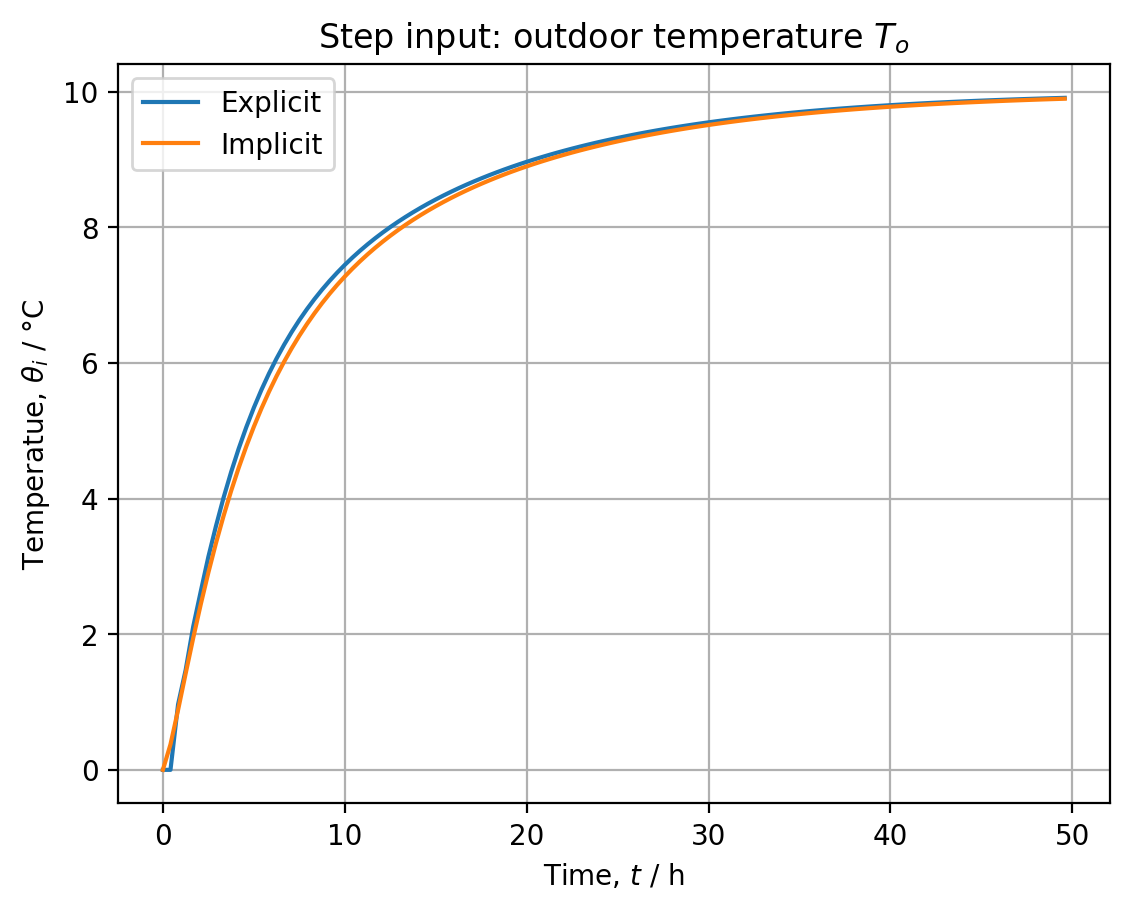

In [39]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

> Figure 8. Step response to outdoor temperature by using Euler
[implicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Backward_Euler_method)
and
[explicit](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration.

The value the indoor temperature obtained after the [settling time](https://en.m.wikipedia.org/wiki/Settling_time) is almost equal to the value obtained in steady-state.

In [40]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss):.4f} °C')
print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: 10.0000 °C
- state-space model: 10.0000 °C
- steady-state response to step input: 9.9064 °C


### Simulation with weather data

#### Start and end time
The simulation will be done from `start_date` to `end_date` indicated in the format `MM-DD HH:MM:SS` (month, day, hour:minute:second).

In [41]:
start_date = '02-01 12:00:00'
end_date = '02-07 18:00:00'

The weather data are for a year. The choice of `2000` for the year is arbitrary; it used in order to respect the format `YYYY-MM-DD HH:MM:SS`.

In [42]:
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

2000-02-01 12:00:00 	start date
2000-02-07 18:00:00 	end date


#### Inputs
##### Read weather data
Dynamic simulation needs [time series](https://en.m.wikipedia.org/wiki/Time_series) of weather data for air temperature, direct solar radiation on a normal surface and diffuse solar radiation on an horizontal surface (see the tutorial on [Weather data and solar radiation](../t01/t01ReadWeatherData.ipynb)).

From the weather data, we select:
- hourly outdoor air temperature, °C;
- hourly solar [direct normal irradiance](https://en.m.wikipedia.org/wiki/Direct_insolation) (or beam radiation), W/m²;
- hourly solar diffuse horizontal irradiance (or [diffuse sky radiation](https://en.wikipedia.org/wiki/Diffuse_sky_radiation)), W/m².

In [43]:
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

The year is set to `2000` by convention and the data is selected from start to end.

In [44]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

##### Solar irradiance on the walls
For the surface orientation given by `slope`, `azimuth`and `latitude`, and the `albedo` of the surface in front of the wall, by using the weather data, we can calculate the:
- direct irradiance, W/m²,
- diffuse irradiance, W/m²,
- reflected irradiance, W/m²,
​
for hourly solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance) on a tilted surface.

<div>
<img src="./figures_project/geographicalOrientationBuilding.png" width="800"/>
</div>

> Figure 9. Geographical orientation of the cubic building.

Note: The numbering of the walls and windows in the listing above refers to the numbering in Figures 3 and 5.

In [45]:
surfaceOrientation_wow5 = {'slope': 0,
                           'azimuth': 0,   # Not relevant as slope is 0 degrees
                           'latitude': 45}

surfaceOrientation_ww12 = {'slope': 90,
                          'azimuth': 270,
                          'latitude': 45}

surfaceOrientation_ww34 = {'slope': 90,
                          'azimuth': 180,
                          'latitude': 45}

albedo = 0.2
rad_surf_wow5 = dm4bem.sol_rad_tilt_surf(weather, surfaceOrientation_wow5, albedo)
rad_surf_ww12  = dm4bem.sol_rad_tilt_surf(weather, surfaceOrientation_ww12, albedo)
rad_surf_ww34  = dm4bem.sol_rad_tilt_surf(weather, surfaceOrientation_ww34, albedo)

The total solar [irradiance](https://en.m.wikipedia.org/wiki/Solar_irradiance)  $E_{tot}$, in W/m², is the sum of direct, diffuse, and reflected components. 

In [46]:
rad_surf_wow5['Φtot_wow5'] = rad_surf_wow5.sum(axis=1)
rad_surf_ww12['Φtot_ww12']  = rad_surf_ww12.sum(axis=1)
rad_surf_ww34['Φtot_ww34']  = rad_surf_ww34.sum(axis=1)

##### Resample the weather data
The weather data is at the time-step of 1h. It needs to be resampled at time step $\Delta t$ used for numerical integration.

In [47]:
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf_wow5['Φtot_wow5'], rad_surf_ww12['Φtot_ww12'], rad_surf_ww34['Φtot_ww34']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear', limit_direction='both')
data = data.rename(columns={'temp_air': 'To'})
data = data.rename_axis('Time')
pd.DataFrame(data)

,To,Φtot_wow5,Φtot_ww12,Φtot_ww34
Time,,,,
2000-02-01 11:40:00+01:00,11.0,63.800000,40.600000,40.600000
2000-02-01 12:05:00+01:00,11.0,63.800000,40.600000,40.600000
2000-02-01 12:30:00+01:00,11.0,63.800000,40.600000,40.600000
2000-02-01 12:55:00+01:00,11.0,63.800000,40.600000,40.600000
2000-02-01 13:20:00+01:00,11.0,63.800000,40.600000,40.600000
...,...,...,...,...
2000-02-07 16:00:00+01:00,6.0,81.400007,51.800014,51.800014
2000-02-07 16:25:00+01:00,6.0,81.400007,51.800014,51.800014
2000-02-07 16:50:00+01:00,6.0,81.400007,51.800014,51.800014


##### Input vector in time
The input is formed by the vectors of time series of temperature sources $\left [ T_o, T_o ,T_o, T_o, To \right ]^T$ and vectors of time series of the heat flow sources $\left [ \Phi_0, \Phi_1, \Phi_2, \Phi_3, \Phi_4 ,\Phi_5 ,\Phi_5, \Phi_7 \right ]^T$:

$$u = 
\begin{bmatrix}
T_o\\ 
T_o\\ 
T_o\\ 
T_o\\ 
\Phi_0\\ 
\Phi_1\\ 
\Phi_2\\ 
\Phi_3\\
\Phi_4\\
\Phi_5\\
\Phi_6\\
\Phi_7\\
\end{bmatrix}
= \begin{bmatrix}
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
T_{o(0)} & T_{o(1)}& ... & T_{o(n-1)}\ \\ 
\Phi_{0(0)} & \Phi_{0(1)} & ... & \Phi_{0(n-1)}\\
\Phi_{1(0)} & \Phi_{1(1)} & ... & \Phi_{1(n-1)}\\
\Phi_{2(0)} & \Phi_{2(1)} & ... & \Phi_{2(n-1)}\\
\Phi_{3(0)} & \Phi_{3(1)} & ... & \Phi_{3(n-1)}\\
\Phi_{4(0)} & \Phi_{4(1)} & ... & \Phi_{4(n-1)}\\
\Phi_{5(0)} & \Phi_{5(1)} & ... & \Phi_{5(n-1)}\\
\Phi_{6(0)} & \Phi_{6(1)} & ... & \Phi_{6(n-1)}\\
\Phi_{7(0)} & \Phi_{7(1)} & ... & \Phi_{7(n-1)}\\
\end{bmatrix}$$


where:

$T_o$: the time series vector of outdoor temperatures (from weather data), °C.

$\Phi_0, \Phi_3, \Phi_6 $: time series vector of solar (i.e. short wave) radiation, in W, absorbed by the outdoor surface of the walls:

$$\Phi_o = \alpha_{w,SW} S_w E_{tot}$$

where:

- $\alpha_{w,SW}$ is the absortion coefficient of the outdoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_w$ - surface area of the wall, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

$\Phi_1, \Phi_4, \Phi_7$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surfaces of the walls:

$$\Phi_i = \tau_{g,SW}  \alpha_{w,SW} S_g E_{tot}$$

where:
- $\tau_{g,SW}$ is the transmission coefficient of the window glass, $0 \leqslant \tau_{g,SW} \leqslant 1$;
- $\alpha_{w,SW}$ - absortion coefficient of the indoor surface of the wall in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the window glass, m²;
- $E_{tot}$ - total solar radiation intensity on the wall, W/m².

$\Phi_2, \Phi_5$: time series vector of short wave (i.e. solar) radiation, in W, absorbed by the windows:

$$\Phi_w = \alpha_{g,SW} S_g E_{tot}$$

where:
- $\alpha_{g,SW}$ is the absortion coefficient of the glass window in short wave, $0 \leqslant \alpha_{w,SW} \leqslant 1$;
- $S_g$ - surface area of the glass window, m²;
- $E_{tot}$ - total solar irradiation on the wall, W/m².

For the sake of simplicity, all the short wave radiation that enters through the windows is summed up and distributed proportionally to the areas of the walls:

$$S_{total} = S_{ww1} + S_{ww3} + S_{wow5}$$

$$\Phi_{1} = \frac{\Phi_{i,sum}}{S_{total}} \cdot S_{ww1}$$

$$\Phi_{4} = \frac{\Phi_{i,sum}}{S_{total}} \cdot S_{ww3}$$

$$\Phi_{7} = \frac{\Phi_{i,sum}}{S_{total}} \cdot S_{wow5}$$

where:
- $\Phi_{i,sum}$ - time series vector of the sum of all the short wave radiation that enters through the windows;
- $S_{total}$ - surface area of the two walls with a window and the wall without the window;
- $\Phi_{1}$ - time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surface of the wall (1) with a window.
- $\Phi_{4}$ - time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surface of the wall (3) with a window.
- $\Phi_{7}$ - time series vector of short wave (i.e. solar) radiation, in W, absorbed by the indoor surface of the wall (5) without a window.

Note: The numbering of the walls refers to the numbering in Figures 3 and 5.

In [48]:
# input vector
To = data['To']

S_total = 2*wall_ww['Surface']['Layer_in'] + wall_wow['Surface']['Layer_in']
Φi_sum = τ_gSW * α_wSW * (wall_ww['Surface']['Window'] * data['Φtot_ww12'] + wall_ww['Surface']['Window'] * data['Φtot_ww34']) # sum of short wave radiation that enters the building

Φ0 = α_wSW * wall_ww['Surface']['Layer_out'] * data['Φtot_ww12']
Φ1 = Φi_sum / S_total * wall_ww['Surface']['Layer_in']
Φ2 = α_gSW * wall_ww['Surface']['Window'] * data['Φtot_ww12']
Φ3 = Φi_sum / S_total * wall_ww['Surface']['Layer_in']
Φ4 = τ_gSW * α_wSW * wall_ww['Surface']['Window'] * data['Φtot_ww34']
Φ5 = α_gSW * wall_ww['Surface']['Window'] * data['Φtot_ww34']
Φ6 = α_wSW * wall_wow['Surface']['Layer_out'] * data['Φtot_wow5']
Φ7 = Φi_sum / S_total * wall_wow['Surface']['Layer_in']


u = pd.concat([To, To, To, To, To, Φ0, Φ1, Φ2, Φ3, Φ4, Φ5, Φ6, Φ7], axis=1)
u.columns.values[[5, 6, 7, 8, 9, 10, 11, 12]] = ['Φ0', 'Φ1', 'Φ2', 'Φ3', 'Φ4', 'Φ5', 'Φ6', 'Φ7']
pd.DataFrame(u)

,To,To,To,To,To,Φ0,Φ1,Φ2,Φ3,Φ4,Φ5,Φ6,Φ7
Time,,,,,,,,,,,,,
2000-02-01 11:40:00+01:00,11.0,11.0,11.0,11.0,11.0,139.562500,4.331250,34.713000,4.331250,6.851250,34.713000,255.200000,5.040000
2000-02-01 12:05:00+01:00,11.0,11.0,11.0,11.0,11.0,139.562500,4.331250,34.713000,4.331250,6.851250,34.713000,255.200000,5.040000
2000-02-01 12:30:00+01:00,11.0,11.0,11.0,11.0,11.0,139.562500,4.331250,34.713000,4.331250,6.851250,34.713000,255.200000,5.040000
2000-02-01 12:55:00+01:00,11.0,11.0,11.0,11.0,11.0,139.562500,4.331250,34.713000,4.331250,6.851250,34.713000,255.200000,5.040000
2000-02-01 13:20:00+01:00,11.0,11.0,11.0,11.0,11.0,139.562500,4.331250,34.713000,4.331250,6.851250,34.713000,255.200000,5.040000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-02-07 16:00:00+01:00,6.0,6.0,6.0,6.0,6.0,178.062548,5.526079,44.289012,5.526079,8.741252,44.289012,325.600028,6.430347
2000-02-07 16:25:00+01:00,6.0,6.0,6.0,6.0,6.0,178.062548,5.526079,44.289012,5.526079,8.741252,44.289012,325.600028,6.430347
2000-02-07 16:50:00+01:00,6.0,6.0,6.0,6.0,6.0,178.062548,5.526079,44.289012,5.526079,8.741252,44.289012,325.600028,6.430347


#### Initial conditions
The initial value of the state-vector can be zero or different from zero.

In [49]:
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#### Time integration
[Explicit Euler](https://en.m.wikipedia.org/wiki/Numerical_methods_for_ordinary_differential_equations#Euler_method) integration in time,

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

where $k = 0, ... , n - 1$,

In [50]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):

$$y = C_s \theta_s + D_s u$$

In [51]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T

In [52]:
data['θi_exp'] = y_exp.T

<Figure size 640x480 with 0 Axes>

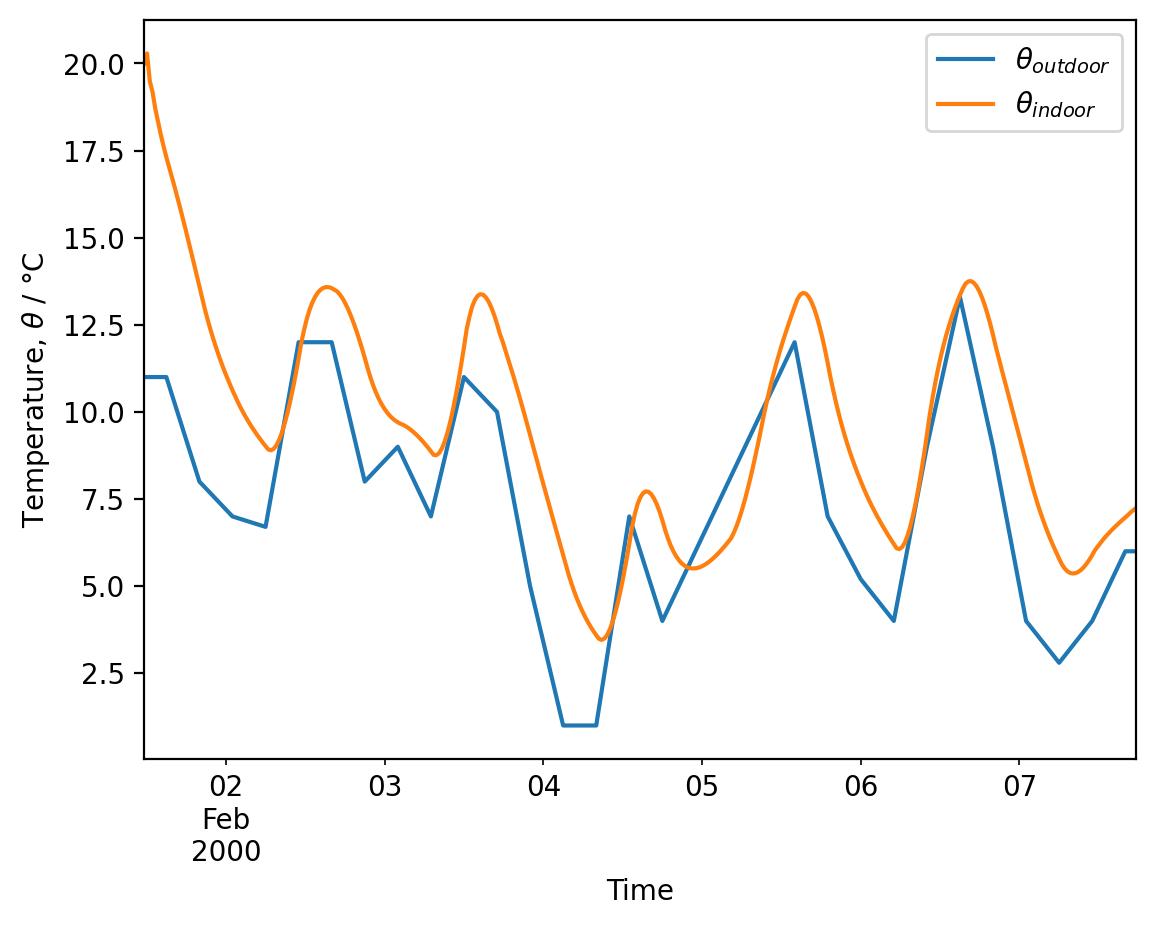

In [53]:
fig = plt.figure()
data[['To', 'θi_exp']].plot(xticks=[],
                            ylabel='Temperature, $θ$ / °C');
plt.legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')
plt.show()

> Figure 10. Simulation of indoor and outdoor temperatures in free-running with weather data using Euler explicit method of integration.

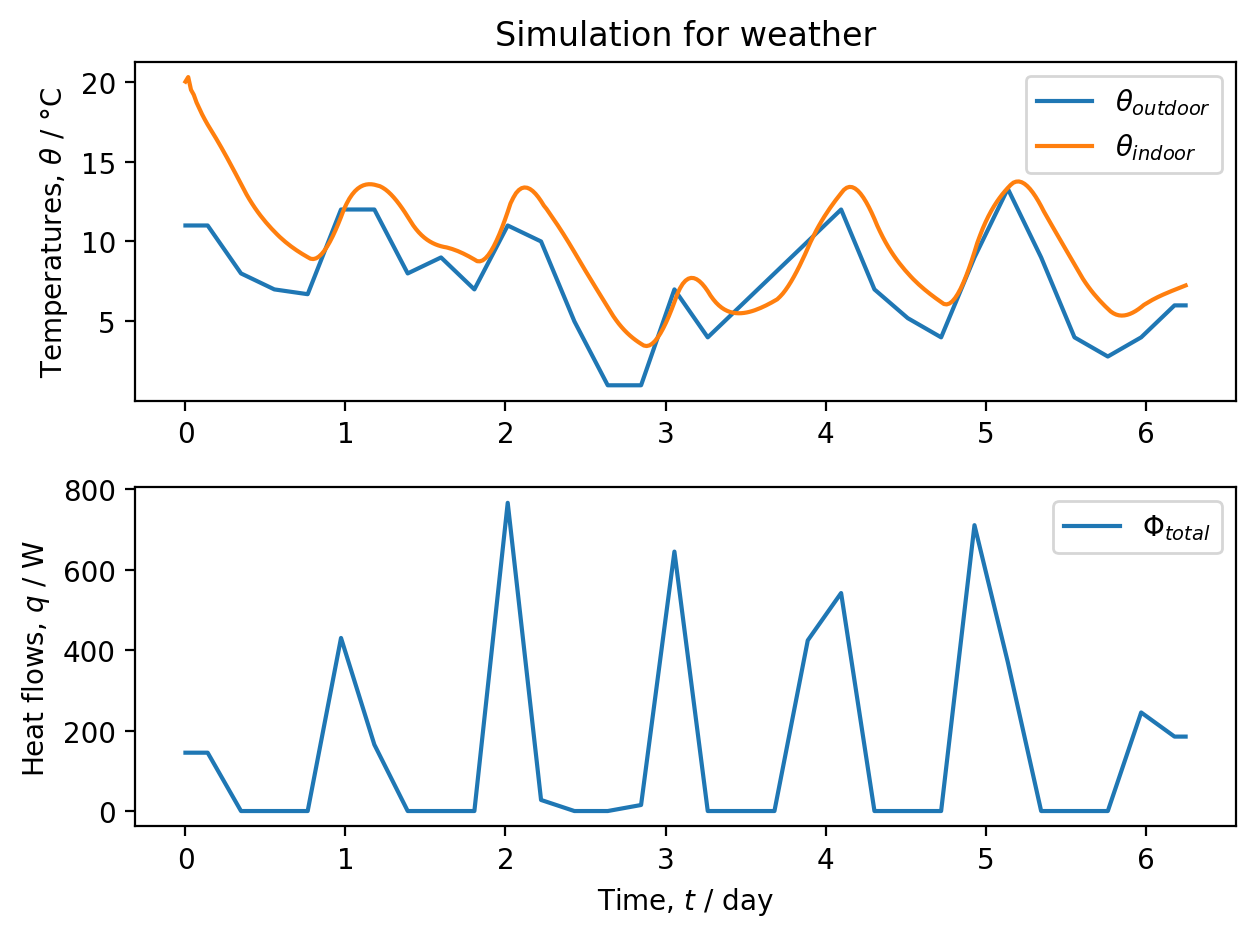

In [54]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['To'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot_wow5'] + data['Φtot_ww12'] + data['Φtot_ww34'], label='$Φ_{total}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()

> Figure 11. Simulation in free-running with weather data using Euler explicit method of integration.

## Discussion

Interchange the materials  of the layers of the wall. Discuss the step responses and the simuation for weather. Give arguments for the advantages and the disadvanted of indoor and outdoor insulation.

The time step depends on:
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and of the glass $C_g =$ `C['Window']` are considered, then the time step is small;
    - if the capacities of the air and of the glass are zero, then the time step is large (and the order of the state-space model is reduced).

## References

1. C. Ghiaus (2013) Causality issue in the heat balance method for calculating the design heating and cooling loads, *Energy* 50: 292-301, https://doi.org/10.1016/j.energy.2012.10.024, open access preprint: [HAL-03605823](https://hal.archives-ouvertes.fr/hal-03605823/document)

2. C. Ghiaus (2021). Dynamic Models for Energy Control of Smart Homes, in *S. Ploix M. Amayri, N. Bouguila (eds.) Towards Energy Smart Homes*, Online ISBN: 978-3-030-76477-7, Print ISBN: 978-3-030-76476-0, Springer, pp. 163-198 (ref.)
[DOI 10.1007/978-3-030-76477-7_5](https://doi.org/10.1007/978-3-030-76477-7_5), open access preprint: [HAL 03578578](https://hal.archives-ouvertes.fr/hal-03578578/document)

3. J.A. Duffie, W. A. Beckman, N. Blair (2020) [Solar Engineering of Thermal Processes](https://www.eng.uc.edu/~beaucag/Classes/SolarPowerForAfrica/Solar%20Engineering%20of%20Thermal%20Processes,%20Photovoltaics%20and%20Wind.pdf), 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

4. [Réglementation Thermique 2005. Méthode de calcul Th-CE.](https://pdfslide.fr/documents/rt2005-methode-de-calcul-th-ce.html) Annexe à l’arrêté du 19 juillet 2006

5. H. Recknagel, E. Sprenger, E.-R. Schramek (2013) Génie climatique, 5e edition, Dunod, Paris. ISBN 978-2-10-070451-4

§. J.R. Howell et al. (2021) Thermal Radiation Heat Transfer 7th edition, ISBN 978-0-367-34707-0, [A Catalogue of Configuration Factors](http://www.thermalradiation.net/indexCat.html)

7. J. Widén, J. Munkhammar (2019) [Solar Radiation Theory](http://www.diva-portal.org/smash/get/diva2:1305017/FULLTEXT01.pdf), Uppsala University